In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import profile_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score

from imblearn.over_sampling import SMOTE

In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv("train_ctrUa4K.csv") # Read train dataset

In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
train.profile_report() # Using profilre report for quick overview of the dataset

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Preprocessing

In [7]:
# Total no of missing values in each column train dataset
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
# Keeping Loan_ID separate
train_Loan_ID = train["Loan_ID"]
# Dropping the Loan_ID column
train.drop(columns="Loan_ID", inplace=True)

In [9]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [10]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [11]:
train.select_dtypes(include="object") # Selectinjg columns with object dtype

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
611,Male,Yes,1,Graduate,No,Urban,Y
612,Male,Yes,2,Graduate,No,Urban,Y


### Filling missing Values

In [12]:
from pandas.api.types import is_string_dtype,is_numeric_dtype# To check whether a column is string or not

In [13]:
def fillna_object_column(dataframe):
    '''
    Function to fill null values in object/string columns
    '''
    columns = dataframe.columns
    for column in columns:
        if is_string_dtype(train[column]):
            most_frequent_value = dataframe[column].mode()[0]
            dataframe[column].fillna(value=most_frequent_value, inplace=True)

In [14]:
# Filing null values of object in train dataset
fillna_object_column(train)

In [15]:
def fillna_numeric_column(dataframe):
    '''
    Function to fill null values in object/string columns
    '''
    columns = dataframe.columns
    for column in columns:
        if is_numeric_dtype(train[column]):
            most_frequent_value = dataframe[column].mean()
            dataframe[column].fillna(value=most_frequent_value, inplace=True)

In [16]:
# Filing null values of integer/float columns in train dataset
fillna_numeric_column(train)

In [17]:
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Creating dummy variable or categorical column for each category of object column / encoding categorical values

In [18]:
train = pd.get_dummies(data=train, 
               columns=["Gender", "Married", "Education", "Self_Employed"], 
               prefix=["Gender", "Married", "Education", "Self_Employed"], 
               drop_first=True)

train = pd.get_dummies(data=train,
                     columns=["Dependents", "Property_Area"],
                     prefix=["Dependents", "Property_Area"])

train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,146.412162,360.0,1.0,Y,1,0,0,0,1,0,0,0,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,N,1,1,0,0,0,1,0,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,Y,1,1,0,1,1,0,0,0,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,Y,1,1,1,0,1,0,0,0,0,0,1
4,6000,0.0,141.000000,360.0,1.0,Y,1,0,0,0,1,0,0,0,0,0,1


In [19]:
# def create_dummy(dataframe):
#     columns = dataframe.select_dtypes(include="object")
#     for column in columns:
#         if dataframe[column].nunique() <= 2:
#             dataframe = pd.get_dummies(data=dataframe, columns=[column], prefix=column, drop_first=True)
#         else:
#             dataframe = pd.get_dummies(data=dataframe, columns=[column], prefix=column)

### Encoding the target variable

In [20]:
train["Loan_Status"].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

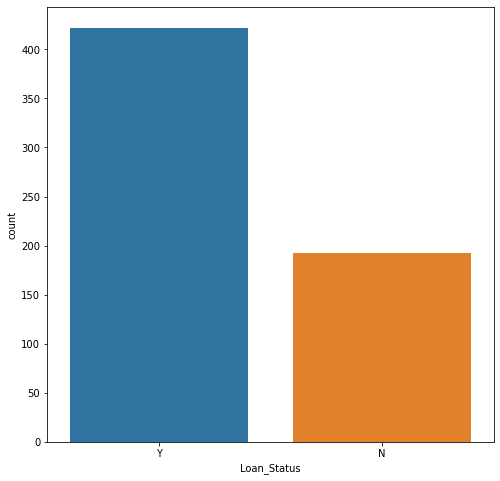

In [21]:
plt.figure(figsize=(8,8))
sns.countplot(x="Loan_Status", data=train)

##### As we can see the data is imbalanced so we need to oversamplt the minority class i.e 'N' in order to make it equal to the majority class label which is 'Y'

In [22]:
# Encoding the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # Initialzie the encoder
train["Loan_Status"] = le.fit_transform(train["Loan_Status"]) 
train["Loan_Status"].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

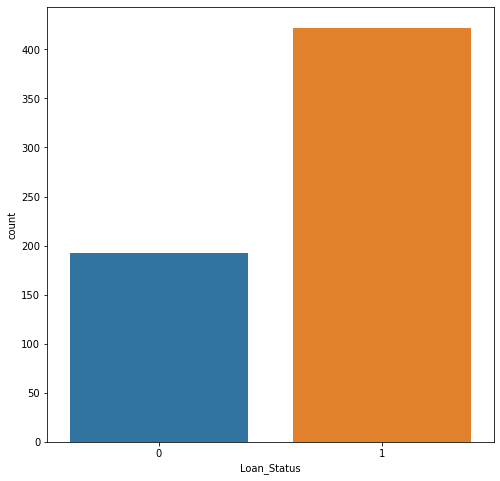

In [23]:
plt.figure(figsize=(8,8))
sns.countplot(x="Loan_Status", data=train)

### Splitting the dataset and applying machine learning algorithms


In [24]:
X = train.drop(columns="Loan_Status") # Input Features
y = train["Loan_Status"] # Target variable

In [25]:
X.shape, y.shape

((614, 16), (614,))

#### Balancing the target variable using SMOTE

In [26]:
# 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [27]:
from collections import Counter
print("Before SMOTE: ", Counter(train["Loan_Status"]))
print("After SMOTE: ", Counter(y))

Before SMOTE:  Counter({1: 422, 0: 192})
After SMOTE:  Counter({1: 422, 0: 422})


In [28]:
# Splitting the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Scaling the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

In [29]:
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(),
    "DTC": DecisionTreeClassifier(),
    "SVC": SVC()
}



for model_name, model in models.items():
    print("Train {}".format(model_name))
    # cross_val_score for each classifier
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    print("List of scores for {}: {}".format(model_name, scores))
    print("The mean score for {}: {}".format(model_name, scores.mean()))
    print("-------------The End------------------")

Train LogReg
List of scores for LogReg: [0.82222222 0.85925926 0.78518519 0.84444444 0.82222222]
The mean score for LogReg: 0.8266666666666668
-------------The End------------------
Train KNN
List of scores for KNN: [0.7037037  0.82222222 0.74074074 0.80740741 0.81481481]
The mean score for KNN: 0.7777777777777778
-------------The End------------------
Train RF
List of scores for RF: [0.81481481 0.85925926 0.81481481 0.85925926 0.84444444]
The mean score for RF: 0.8385185185185184
-------------The End------------------
Train DTC
List of scores for DTC: [0.76296296 0.79259259 0.74814815 0.85185185 0.78518519]
The mean score for DTC: 0.7881481481481483
-------------The End------------------
Train SVC
List of scores for SVC: [0.80740741 0.87407407 0.79259259 0.87407407 0.83703704]
The mean score for SVC: 0.837037037037037
-------------The End------------------


#### Using Logistic Regression Model

In [30]:
LogReg = LogisticRegression(max_iter=2000, random_state=42)
LogReg.fit(X_train_scaled, y_train)
LogReg_pred = LogReg.predict(X_test_scaled)

# Evaluation Metrics
accuracy_LogReg = accuracy_score(y_test, LogReg_pred)
f1_LogReg = f1_score(y_test, LogReg_pred)
precision_LogReg = precision_score(y_test, LogReg_pred)
recall_LogReg = recall_score(y_test, LogReg_pred)
roc_LogReg = roc_auc_score(y_test, LogReg_pred)
print(accuracy_LogReg)

0.834319526627219


#### Using RandomForrestClassifier

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
rfc_pred = rfc.predict(X_test_scaled)

# Evaluation Metrics
accuracy_rfc = accuracy_score(y_test, rfc_pred)
f1_rfc = f1_score(y_test, rfc_pred)
precision_rfc = precision_score(y_test, rfc_pred)
recall_rfc= recall_score(y_test, rfc_pred)
roc_rfc = roc_auc_score(y_test, rfc_pred)
print(accuracy_rfc)

0.8224852071005917


#### Using SupportVectorClassifier

In [32]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
svc_pred = rfc.predict(X_test_scaled)

# Evaluation Metrics
accuracy_svc = accuracy_score(y_test, svc_pred)
f1_svc = f1_score(y_test, svc_pred)
precision_svc = precision_score(y_test, svc_pred)
recall_svc = recall_score(y_test, svc_pred)
roc_svc = roc_auc_score(y_test, svc_pred)
print(accuracy_svc)

0.8224852071005917


### Table of Evaluation Metrics

In [33]:
eval_table = pd.DataFrame({
    'Algoritm':['LogisticRegression','RandomForrestClassifier','SupportVectorClassifier'],
    'Accuracy':[accuracy_LogReg, accuracy_rfc, accuracy_svc],
    "F1 score":[f1_LogReg, f1_rfc, f1_svc],
    "Precision":[precision_LogReg, precision_rfc, precision_svc],
    "Recall":[recall_LogReg, recall_rfc, recall_svc],
    "ROC":[roc_LogReg, roc_rfc, roc_svc]
    
})

eval_table

,Algoritm,Accuracy,F1 score,Precision,Recall,ROC
0,LogisticRegression,0.834320,0.835294,0.747368,0.946667,0.845674
1,RandomForrestClassifier,0.822485,0.814815,0.758621,0.880000,0.828298
2,SupportVectorClassifier,0.822485,0.814815,0.758621,0.880000,0.828298
